# Multi-Agentic Medical Intelligent Assistant

#### Universidad Complutense de Madrid

##### Máster Big Data, Data Science & Inteligencia Artificial 2024-2025 

##### TRABAJO FIN DE MASTER

* Alumno: Marco Prado Rodriguez
* Correo: marcopra@ucm.es

### Project Objective

Develop a multi-agent system that combines large language models with a medical convolutional neural network to assist radiologists in interpreting and diagnosing medical imaging studies.

## Libraries and Variables

In [ ]:
# Libraries
#import asyncio
import os
from dotenv import load_dotenv
import json

# Semantic Kernel Orchestration and Agents libraries
from semantic_kernel.agents import Agent, ChatCompletionAgent, GroupChatOrchestration, RoundRobinGroupChatManager
from semantic_kernel.agents.runtime import InProcessRuntime
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.contents import ChatMessageContent

# Azure Machine Learning libraries
from azure.ai.ml import MLClient
from azure.identity import ClientSecretCredential

# Import image handling utilities (module file should be named image_handle.py inside utils)
from utils.imagehandle import read_image, write_request_file, write_request_file_frontal_only, adjust_box_for_original_image_size, show_image_with_bbox

In [ ]:
# Load environment variables
load_dotenv()

# Variables - Azure Services
azaifoundry_ep=os.environ["AZURE_AIFOUNDRY_ENDPOINT"]
azaifoundry_key=os.environ["AZURE_AIFOUNDRY_API_KEY"]
aml_tenant_id=os.environ["AZURE_AML_TENANT_ID"]
aml_client_id=os.environ["AZURE_AML_CLIENT_ID"]
aml_client_secret=os.environ["AZURE_AML_CLIENT_SECRET"]
aml_endpoint_name=os.environ["AZURE_AML_ENDPOINT_NAME"]

# Variables - Azure AI Models
azaifoundry_model=os.environ["AZURE_AIFOUNDRY_BASE_MODEL"]
llama_deployment_name = os.environ.get("AZURE_AIFOUNDRY_LLAMA_MODEL")
deepseek_deployment_name = os.environ.get("AZURE_AIFOUNDRY_DEEPSEEK_MODEL")
aml_deployment_name=os.environ["AZURE_AML_DEPLOYMENT_NAME"] # CXRReportGen Model

## Call the specialized Radiology AI Model (CXRReportGen )

In [3]:
# Azure AML Client Connection
credential_aml = ClientSecretCredential(
    tenant_id=aml_tenant_id,
    client_id=aml_client_id,
    client_secret=aml_client_secret,
)

registry_ml_client = MLClient(
    credential_aml,
    registry_name="azureml",
)

ml_client = MLClient.from_config(credential_aml)

Found the config file in: C:\Users\maprado\Desktop\AI\ucm\models\config.json
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


In [ ]:
# Now let's pass frontal and lateral images to the model and visualize the results

frontal = "cxrdata/cxr_frontal.jpg"
lateral = "cxrdata/cxr_lateral.jpg"

indication = ""
technique = ""
comparison = "None"

if lateral not in (None, "", "None"):
    request_file_name = write_request_file(
        frontal, lateral, indication, technique, comparison
    )
else:
    request_file_name = write_request_file_frontal_only(
        frontal, indication, technique, comparison
    )

# Call the AML endpoint with the request file
response = ml_client.online_endpoints.invoke(
    endpoint_name=aml_endpoint_name,
    deployment_name=aml_deployment_name,
    request_file=request_file_name,
)
# Parse the response into an array
findings = json.loads(json.loads(response)[0]["output"])

# Create a diagnostic report string from the findings
diagnostic_report = ""
for finding in findings:
    diagnostic_report += finding[0] + "\n"

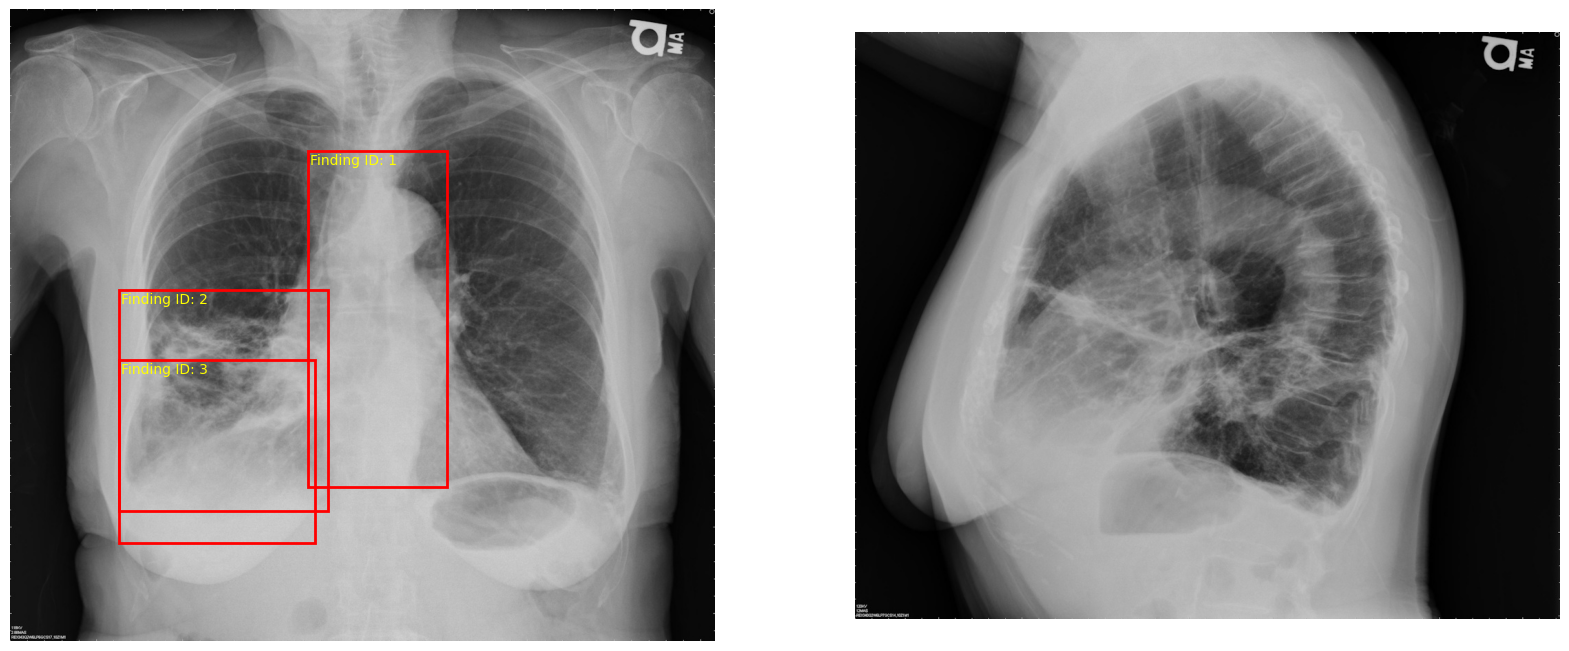

0. The heart size is normal. 
1. The aorta is tortuous. * 
2. A patchy infiltrate in the right lower lobe is associated with volume loss. * 
3. A small right pleural effusion is present. * 
4. The left hemithorax is grossly clear. 


In [5]:
# Display the image with bounding boxes of the findings and labels
show_image_with_bbox(frontal, findings, path_lateral=lateral)

## Create the Agentic Orchestration

In [ ]:
# Create Azure Chat Completion instances for different LLM models

# Base model = gpt-5-chat
az_chat_completion = AzureChatCompletion(
    deployment_name=azaifoundry_model,
    api_key=azaifoundry_key,
    endpoint=azaifoundry_ep
)
# Llama model = Llama-4-Maverick-17B-128E-Instruct-FP8
az_llama_chat_completion = AzureChatCompletion(
    deployment_name=llama_deployment_name,
    api_key=azaifoundry_key,
    endpoint=azaifoundry_ep
)
# DeepSeek model = DeepSeek-R1-0528
az_deepseek_chat_completion = AzureChatCompletion(
    deployment_name=deepseek_deployment_name,
    api_key=azaifoundry_key,
    endpoint=azaifoundry_ep
)

In [7]:
# LLM Agents definition
def get_agents() -> list[Agent]:
    """Return a list of agents that will participate in the group style discussion.

    Feel free to add or remove agents.
    """
    doctor_main_agent = ChatCompletionAgent(
        name="MainDoctor",
        description="Main Doctor",
        instructions=(
            "You are a Doctor and provide medical information and diagnosis. "
            "You are given a patient's symptoms and history, and you must provide a diagnosis. "
            "Do not fabricate findings."
        ),
        service=az_chat_completion
    )
    doctor_research_agent = ChatCompletionAgent(
        name="ResearchDoctor",
        description="Research Doctor",
        instructions=(
            "You are a doctor who reviews other doctors' assessments."
            "You are given a patient's symptoms and history, and you must provide a diagnosis. "
            "You must provide a second opinion on the diagnosis provided by other doctors. "
            "Do not fabricate findings."
        ),
        service=az_llama_chat_completion
    )
    radiology_agent = ChatCompletionAgent(
    name="RadiologyAgent",
    description="Analyzes radiographic images diagnostics and provides DIAGNOSTIC observations.",
    instructions=(
        "You are a radiology Doctor. Provide structured observations (findings + impressions) "
        "from the supplied image diagnostics. "
        "Do not fabricate findings."
    ),
    service=az_deepseek_chat_completion
)
    # The order of the agents in the list will be the order in which they will be picked by the round robin manager
    return [radiology_agent, doctor_main_agent, doctor_research_agent]

In [8]:
# Callback function to print agent responses
def agent_response_callback(message: ChatMessageContent) -> None:
    """Observer function to print the messages from the agents."""
    print(f"**{message.name}**\n{  message.content}\n\n")

In [ ]:
# Create a group chat orchestration with a round robin manager
agents = get_agents()
group_chat_orchestration = GroupChatOrchestration(
    members=agents,
    # max_rounds is odd, so that the writer gets the last round
    manager=RoundRobinGroupChatManager(max_rounds=6),
    agent_response_callback=agent_response_callback,
)

In [ ]:
# Create a runtime and start it
runtime = InProcessRuntime()
runtime.start()

**RadiologyAgent**

### Structured Radiology Report  

#### **Findings:**  
1. **Cardiac Silhouette:**  
   - Heart size is within normal limits.  
2. **Aorta:**  
   - Tortuous configuration noted.  
3. **Right Lung:**  
   - Patchy infiltrate observed in the right lower lobe.  
   - Associated volume loss in the right lower lobe.  
4. **Pleura:**  
   - Small right pleural effusion present.  
5. **Left Lung:**  
   - Grossly clear, with no focal consolidations, masses, or effusions.  

#### **Impressions:**  
1. **Cardiovascular:**  
   - Normal cardiac size.  
   - Tortuous aorta, suggestive of age-related or atherosclerotic changes.  
2. **Right Lung Pathology:**  
   - Patchy infiltrate in the right lower lobe with volume loss, consistent with possible pneumonia, atelectasis, or inflammatory process.  
3. **Pleural Abnormality:**  
   - Small right pleural effusion, likely reactive (e.g., parapneumonic) given the adjacent infiltrate.  
4. **Left Lung:**  
   - No acute abnormaliti

## Query the Multi-Agentic Medical System

In [ ]:
# Invoke the group chat orchestration with a task
orchestration_result = await group_chat_orchestration.invoke(
    task=(
        "Agents Doctors, please review the following patient's radiography image analysis result and provide a diagnosis:\n"
        "Below is the structured diagnostic report extracted from the Radiology Model findings:\n"
        f"{diagnostic_report}\n"
        "Be explicit about each agent's contribution in the final summary."
    ),
    runtime=runtime,
)

In [ ]:
# Wait for the results
value = await orchestration_result.get()
print(f"***** Result *****\n{value}")

# 5. Stop the runtime after the invocation is complete
await runtime.stop_when_idle()

***** Result *****
### Structured Radiology Report (Second Opinion)  

#### **Findings:**  
1. **Cardiac Silhouette:**  
   - Normal size.  
2. **Aorta:**  
   - Tortuous configuration.  
3. **Right Lung:**  
   - Patchy infiltrate in the right lower lobe.  
   - Associated volume loss in the right lower lobe.  
4. **Pleura:**  
   - Small right pleural effusion.  
5. **Left Lung:**  
   - Grossly clear, no acute abnormalities.  

#### **Impressions:**  
1. **Cardiovascular:**  
   - Normal cardiac size.  
   - Tortuous aorta, likely chronic (e.g., age-related, hypertension, or atherosclerosis).  
2. **Right Lung Pathology:**  
   - **Primary Diagnosis:** Patchy infiltrate with volume loss and ipsilateral pleural effusion is **highly suggestive of right lower lobe pneumonia with associated atelectasis and parapneumonic effusion**.  
   - Volume loss implies possible mucus plugging or bronchial obstruction complicating the infectious process.  
3. **Differential Considerations:**  
   -

## Save the diagnosis output to a TXT file in the root

In [13]:
# Write the value result to a diagnosis.txt file
output_path = "diagnosis.txt"
with open(output_path, "w", encoding="utf-8") as f:
	f.write(str(value))

print(f"Diagnosis written to {output_path}")


Diagnosis written to diagnosis.txt
